In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.cuda.set_device(1)

In [4]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
        #self.bert = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.bert(text, labels=label)[:2]

        return loss, text_fea

In [5]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
## tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
source_folder = 'lm_lstm'

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train_bert_lstm.csv', validation='valid_bert_lstm.csv',
                                           test='test_bert_lstm.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=64, device=device, train=False, shuffle=False, sort=False)

In [7]:
destination_folder = 'bert_lstm_lm_new'
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in tqdm(range(num_epochs), desc='epochs'):
        for (text, labels), _ in tqdm(train_loader, desc='training examples'):
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, global_steps_list


model = BERT().to(device)
#load the checkpoint
#load_checkpoint(destination_folder + '/model.pt', model)

optimizer = optim.Adam(model.parameters(), lr=2e-5)

train_loss_list, valid_loss_list, global_steps_list = train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/opt/conda/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/10], Step [887/17750], Train Loss: 0.6956, Valid Loss: 0.6927
Model saved to ==> bert_lstm_lm_new/model.pt
Model saved to ==> bert_lstm_lm_new/metrics.pt
Epoch [1/10], Step [1774/17750], Train Loss: 0.6492, Valid Loss: 0.8882



Epoch [2/10], Step [2661/17750], Train Loss: 0.6706, Valid Loss: 0.6046
Model saved to ==> bert_lstm_lm_new/model.pt
Model saved to ==> bert_lstm_lm_new/metrics.pt
Epoch [2/10], Step [3548/17750], Train Loss: 0.5147, Valid Loss: 0.6635



Epoch [3/10], Step [4435/17750], Train Loss: 0.6226, Valid Loss: 0.5291
Model saved to ==> bert_lstm_lm_new/model.pt
Model saved to ==> bert_lstm_lm_new/metrics.pt
Epoch [3/10], Step [5322/17750], Train Loss: 0.4172, Valid Loss: 0.6579



Epoch [4/10], Step [6209/17750], Train Loss: 0.5771, Valid Loss: 0.4897
Model saved to ==> bert_lstm_lm_new/model.pt
Model saved to ==> bert_lstm_lm_new/metrics.pt
Epoch [4/10], Step [7096/17750], Train Loss: 0.3505, Valid Loss: 0.5775



Epoch [5/10], Step [7983/17750], Train Loss: 0.5363, Valid Loss: 0.4736
Model saved to ==> bert_lstm_lm_new/model.pt
Model saved to ==> bert_lstm_lm_new/metrics.pt
Epoch [5/10], Step [8870/17750], Train Loss: 0.3037, Valid Loss: 0.5237



Epoch [6/10], Step [9757/17750], Train Loss: 0.5035, Valid Loss: 0.4579
Model saved to ==> bert_lstm_lm_new/model.pt
Model saved to ==> bert_lstm_lm_new/metrics.pt
Epoch [6/10], Step [10644/17750], Train Loss: 0.2683, Valid Loss: 0.4896



Epoch [7/10], Step [11531/17750], Train Loss: 0.4741, Valid Loss: 0.4407
Model saved to ==> bert_lstm_lm_new/model.pt
Model saved to ==> bert_lstm_lm_new/metrics.pt
Epoch [7/10], Step [12418/17750], Train Loss: 0.2381, Valid Loss: 0.4600



Epoch [8/10], Step [13305/17750], Train Loss: 0.4460, Valid Loss: 0.4072
Model saved to ==> bert_lstm_lm_new/model.pt
Model saved to ==> bert_lstm_lm_new/metrics.pt
Epoch [8/10], Step [14192/17750], Train Loss: 0.2106, Valid Loss: 0.5139



Epoch [9/10], Step [15079/17750], Train Loss: 0.4242, Valid Loss: 0.4171
Epoch [9/10], Step [15966/17750], Train Loss: 0.1931, Valid Loss: 0.4275



Epoch [10/10], Step [16853/17750], Train Loss: 0.4052, Valid Loss: 0.4106
Epoch [10/10], Step [17740/17750], Train Loss: 0.1746, Valid Loss: 0.4865


Model saved to ==> bert_lstm_lm_new/metrics.pt
Finished Training!


Model loaded from <== bert_lstm_lm_new/metrics.pt


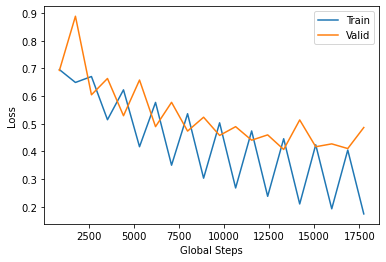

In [8]:
destination_folder = 'bert_lstm_lm_new'
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [9]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    x_text = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in tqdm(test_loader, desc='Testing examples'):
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                x_text.extend(text.tolist())
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['1', '0'])
    ax.yaxis.set_ticklabels(['1', '0'])
    plt.show()
    return x_text, y_pred, y_true


Classification Report:
              precision    recall  f1-score   support

           1     0.8686    0.7353    0.7964      7372
           0     0.7706    0.8888    0.8254      7372

    accuracy                         0.8121     14744
   macro avg     0.8196    0.8121    0.8109     14744
weighted avg     0.8196    0.8121    0.8109     14744



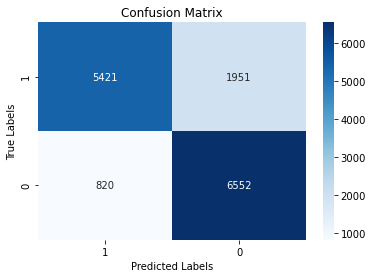

In [10]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = BERT().to(device)
#destination_folder = 'bert_lstm_lm'
#load the checkpoint
#load_checkpoint(destination_folder + '/model.pt', model)

x_text, y_pred, y_true = evaluate(model, test_iter)